### 1 .Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

Импортируем библиотеки

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

Читаем файл и смотрим данные

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Визуализируем данные и визуально оценим данные на стационарность.

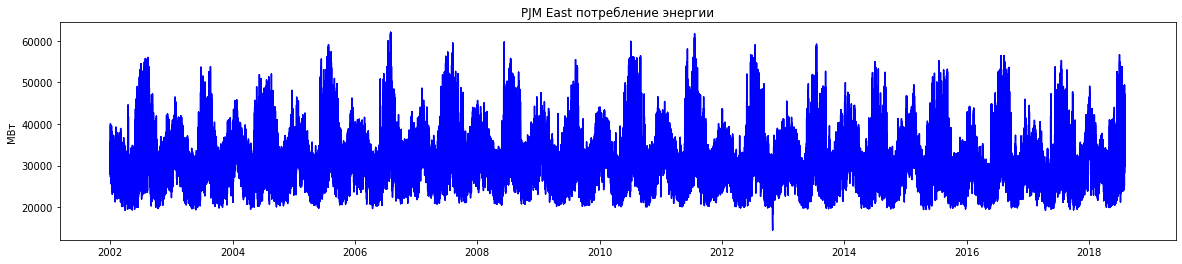

In [3]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Посмотрим более детально данные за 2 года

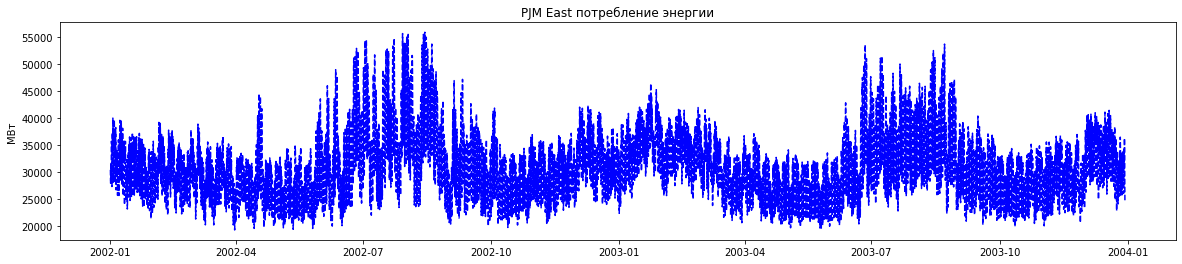

In [4]:
date_time =data['PJME_MW']
date_time.index = pd.date_range(data.index[0], periods=data.index.shape[0], freq="H")
plt.figure(figsize =(20,4))
plt.plot( date_time.index[:24*7*104], date_time.values[:24*7*104], '--b' )

plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Из графиков видно, что данные имеют отчетливую цикличность как по годам так и по сезонам, дням и часам.
Можно предположить, что это не стационарный ряд, т.к. разброс знаений сильно зависит от периода. Но пока рано делать выводы, т.к. сам график похож на "белый шум".

Сделаем ресемплинг данных по дням и месяцам и посмотрим на эти ряды.

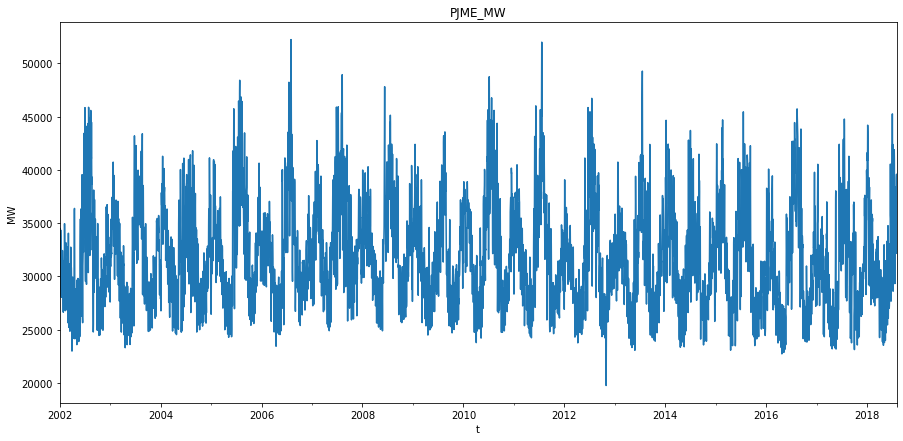

In [5]:
data_d = data.resample('D').mean()
data_d['PJME_MW'].plot(style='-', figsize=( 15, 7 ), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

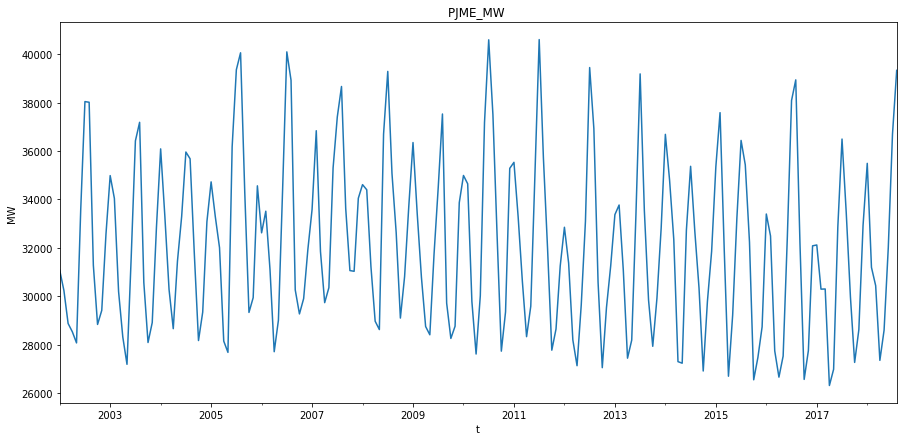

In [6]:
data_m = data.resample('M').mean()
data_m['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

График по месяцам похож на стационарный, но требует дополнительного исследования. График по годам не стационарен и похож на случайное явление.

Посмотрим как ведут себя первые разности.

In [7]:
d_data = data['PJME_MW'].values[1:]-data['PJME_MW'].values[:-1]

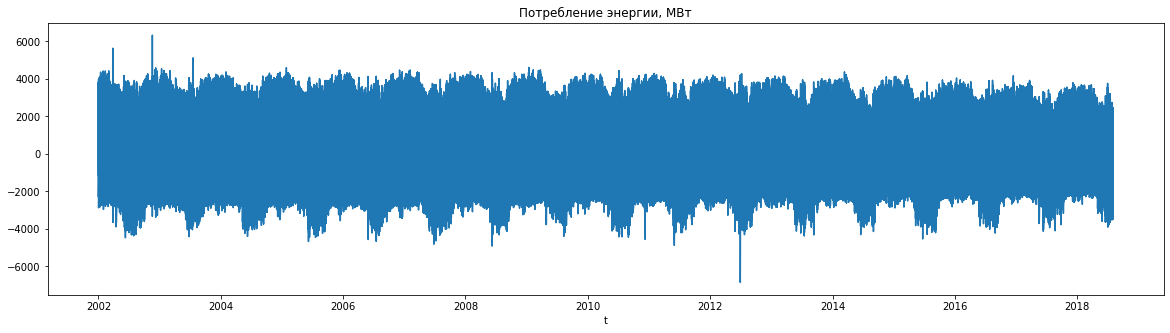

In [8]:
plt.figure(figsize=(20,5))
plt.plot(data.iloc[:-1].index,d_data)
plt.xlabel('t')
plt.title('Потребление энергии, МВт')
plt.show()

График разности выглядит не совсем стационарно.

Обратимся к статистическому метододу. Проведем Расширенный тест Дики-Фуллера. Проведем тест для дневного ресемплинга и для первые разности основных данных.

In [9]:
# Ресемплинг по месяцам
DF_data_d = sm.tsa.stattools.adfuller(data_d['PJME_MW'].values,regression='ctt')
# Первые разности
d_DF_data = sm.tsa.stattools.adfuller(d_data,regression='ctt')

In [10]:
print('коэффициент ADF для ресемплинга по дням: ', DF_data_d[1])
print('коэффициент ADF для 1-й разности потребления энергии: ', d_DF_data[1])

коэффициент ADF для ресемплинга по дням:  4.282974615240694e-11
коэффициент ADF для 1-й разности потребления энергии:  0.0


Из тестов видно, что ряд ресемплинга по дням стационарен, так же как и первой разности.

Сгладим наши данные по методу скользящей средней. Диапазон лага возьмем в 1 неделю.

In [11]:
data_s = pd.DataFrame(data = data_d[['PJME_MW']])

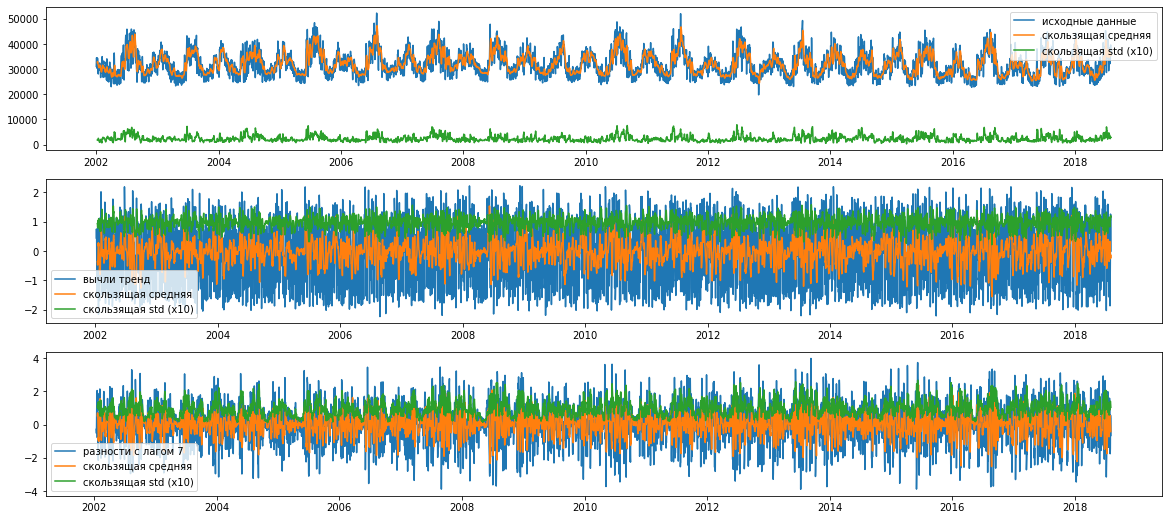

In [12]:
N2 = 7

data_s['z_data'] = (data_s['PJME_MW'] - data_s['PJME_MW'].rolling(window=N2).mean()) / data_s['PJME_MW'].rolling(window=N2).std()
data_s['zp_data'] = data_s['z_data'] - data_s['z_data'].shift(N2)

def plot_rolling(data_s):
    fig, ax = plt.subplots(3,figsize=(20, 9))
    ax[0].plot(data_s.index, data_s['PJME_MW'], label='исходные данные')
    ax[0].plot(data_s['PJME_MW'].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(data_s['PJME_MW'].rolling(window=N2).std(), label="скользящая std (x10)");
    ax[0].legend()

    ax[1].plot(data_s.index,data_s.z_data, label="вычли тренд")
    ax[1].plot(data_s.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(data_s.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[1].legend()

    ax[2].plot(data_s.index, data_s.zp_data, label="разности с лагом " +str(N2))
    ax[2].plot(data_s.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(data_s.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[2].legend()

    plt.show()
plot_rolling(data_s)  

Попробуем применить экспоненциальное сглаживание.

Text(0.5, 1.0, 'PJM East потребление энергии')

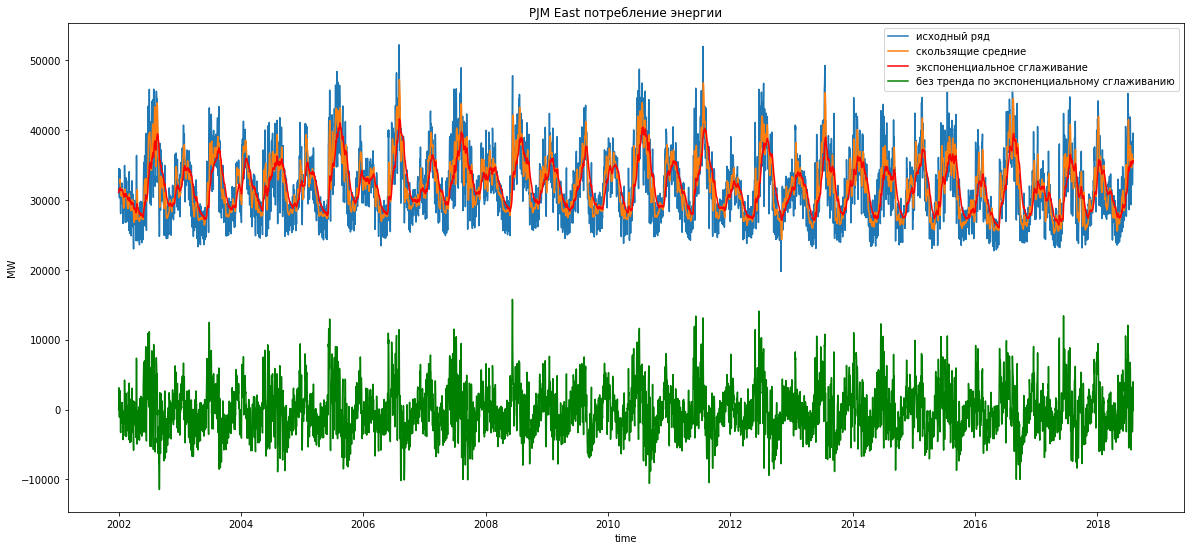

In [13]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_exp_1 = exponential_smoothing(data_d['PJME_MW'], 0.05)

plt.figure(figsize=(20, 9))
plt.plot(data_s.index, data_s['PJME_MW'], label='исходный ряд')
plt.plot(data_s['PJME_MW'].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(data_s.index, data_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(data_s.index, data_s['PJME_MW'] - data_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJM East потребление энергии')

Из графиков ничего не понятно, т.к. слишком много данных. Посмотрим данные на более коротком диапазоне.

Text(0.5, 1.0, 'PJM East потребление энергии')

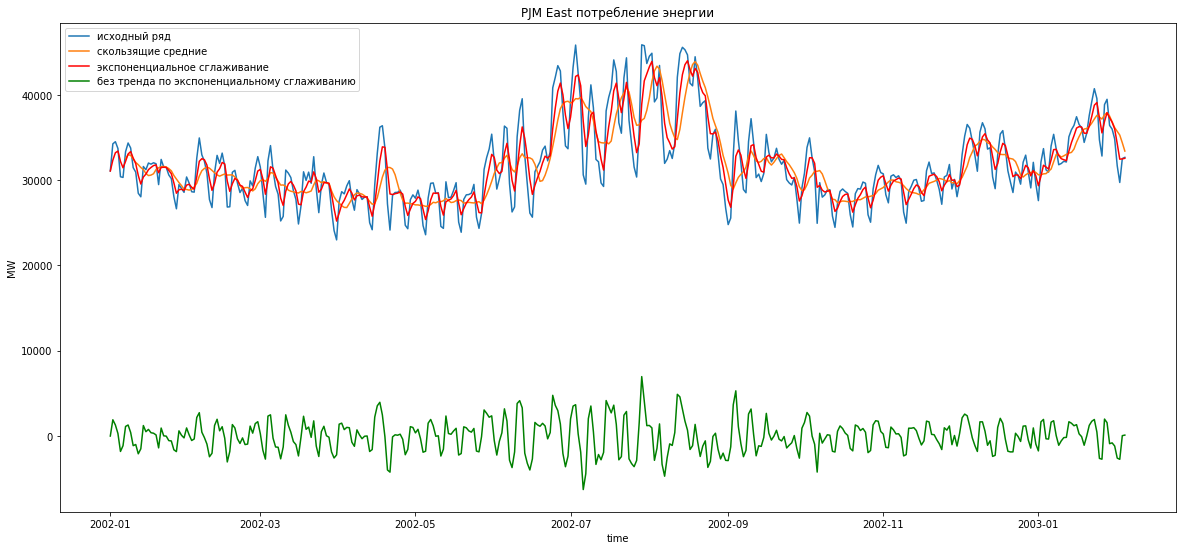

In [14]:
data_exp_1 = exponential_smoothing(data_d['PJME_MW'], 0.4)

plt.figure(figsize=(20, 9))
plt.plot(data_s.index[:400], data_s['PJME_MW'].values[:400], label='исходный ряд')
plt.plot(data_s['PJME_MW'].rolling(window=N2).mean()[:400], label="скользящие средние");

plt.plot(data_s.index[:400], data_exp_1[:400], color = 'red', label="экспоненциальное сглаживание");
plt.plot(data_s.index[:400], data_s['PJME_MW'].values[:400] - data_exp_1[:400], color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJM East потребление энергии')

При экспоненциальном сглаживании очень важно правильно подбирать коэффициент. Если его взять маленьким, то он будет сильно сглаживать. Результаты экспоненциального сглаживания больше похожи на основное направление изменения потребления энергии.

Построим разницу между сглаженой и основной моделями энергопотребления. Проверим его на стационарность.

In [15]:
data_exp_1 = pd.DataFrame(data = data_exp_1, index = data_s.index)
#без тренда 
data_trend_free = (data_s['PJME_MW'] - data_exp_1.iloc[:,0])
data_trend_free.head()

Date
2002-01-01       0.000000
2002-01-02    1908.481522
2002-01-03    1295.288913
2002-01-04     299.323348
2002-01-05   -1806.605991
Freq: D, dtype: float64

In [16]:
DF_data = sm.tsa.stattools.adfuller(data_trend_free , regression = 'ctt')
DF_data

(-11.82795960304032,
 4.1866116176984655e-19,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 101479.16717369945)

В соответствии с тестом ADF - это стационарный ряд.

Теперь займемся прогнозированием энергопотребления. Нужно к нашим данным добавить новых признаков. Т.к. у нак, по факту, есть только исторические данные, то будем манипулировать ими.

In [17]:
df= pd.DataFrame(data_exp_1)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_1'] = exponential_smoothing(df[0], 0.02)
df['exp_0_2'] = exponential_smoothing(df[0], 0.05)
df['exp_0_3'] = exponential_smoothing(df[0], 0.1)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[1:,0]-df.iloc[:-1,0]
# добавим историю на глубину 3 для сглаживания 0.1
df['exp_0_1_t1'] = 0
df.iloc[1:,8]=df.iloc[:-1,4].values
df['exp_0_1_t2'] = 0
df.iloc[2:,9]=df.iloc[:-2,4].values
df['exp_0_1_t3'] = 0
df.iloc[3:,10]=df.iloc[:-3,4].values
# добавим историю на глубину 3 для сглаживания 0.2
df['exp_0_2_t1'] = 0
df.iloc[1:,11]=df.iloc[:-1,5].values
df['exp_0_2_t2'] = 0
df.iloc[2:,12]=df.iloc[:-2,5].values
df['exp_0_2_t3'] = 0
df.iloc[3:,13]=df.iloc[:-3,5].values
# добавим историю на глубину 3 для сглаживания 0.3
df['exp_0_3_t1'] = 0
df.iloc[1:,14]=df.iloc[:-1,6].values
df['exp_0_3_t2'] = 0
df.iloc[2:,15]=df.iloc[:-2,6].values
df['exp_0_3_t3'] = 0
df.iloc[3:,16]=df.iloc[:-3,6].values
# добавим историю на глубину 3 для первой разности
df['duff1_t1'] = 0
df.iloc[1:,8]=df.iloc[:-1,4].values
df['duff1_t2'] = 0
df.iloc[2:,9]=df.iloc[:-2,4].values
df['duff1_t3'] = 0
df.iloc[3:,10]=df.iloc[:-3,4].values


df.head()

C:\Users\Spoukster\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,0,t,t1,t2,exp_0_1,exp_0_2,exp_0_3,diff1,exp_0_1_t1,exp_0_1_t2,exp_0_1_t3,exp_0_2_t1,exp_0_2_t2,exp_0_2_t3,exp_0_3_t1,exp_0_3_t2,exp_0_3_t3,duff1_t1,duff1_t2,duff1_t3
Date,,,,,,,,,,,,,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
2002-01-02,32353.060145,31080.739130,0.000000,0.000000,31106.185551,31144.355181,31207.971232,0.0,31080.739130,0.000000,0.000000,31080.739130,0.000000,0.000000,31080.739130,0.000000,0.000000,0,0,0
2002-01-03,33216.586087,32353.060145,31080.739130,0.000000,31148.393561,31247.966726,31408.832717,0.0,31106.185551,31080.739130,0.000000,31144.355181,31080.739130,0.000000,31207.971232,31080.739130,0.000000,0,0,0
2002-01-04,33416.134986,33216.586087,32353.060145,31080.739130,31193.748390,31356.375139,31609.562944,0.0,31148.393561,31106.185551,31080.739130,31247.966726,31144.355181,31080.739130,31408.832717,31207.971232,31080.739130,0,0,0
2002-01-05,32211.730991,33416.134986,33216.586087,32353.060145,31214.108042,31399.142932,31669.779749,0.0,31193.748390,31148.393561,31106.185551,31356.375139,31247.966726,31144.355181,31609.562944,31408.832717,31207.971232,0,0,0


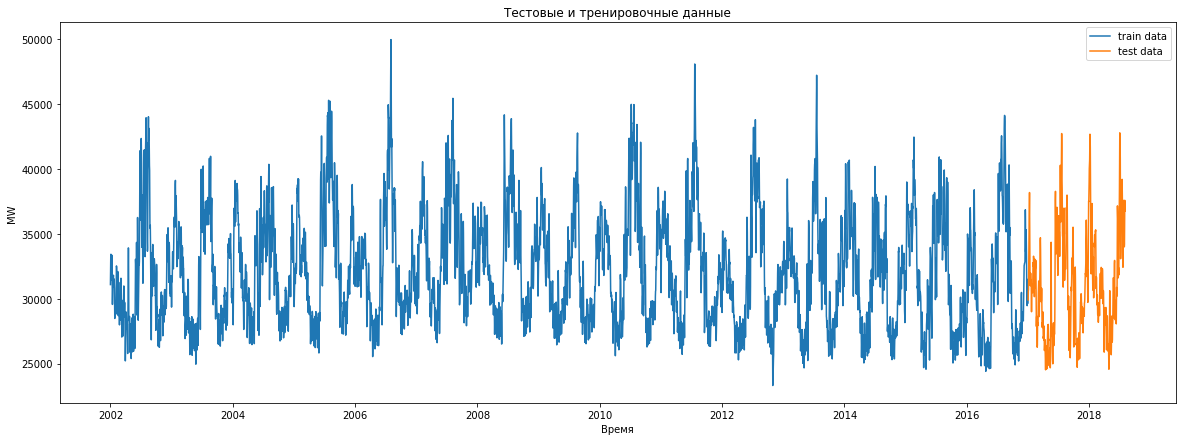

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

# сделаем примеры и модель 
def split_data_b(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train, test = split_data_b(df, '01-01-2017')

X_train = train.iloc[:-1,:]
y_train = train[df.columns[0]].values[1:]
X_test = test.iloc[:-1,:]
y_test = test[df.columns[0]].values[1:]

plt.figure(figsize=(20, 7))
plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(train.index.get_level_values('Date'), train[df.columns[0]], label='train data' )
plt.plot(test.index.get_level_values('Date'), test[df.columns[0]], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=13, random_state=42, n_estimators=100)
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=13,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### 2. Оцените ошибку модели из п.1.

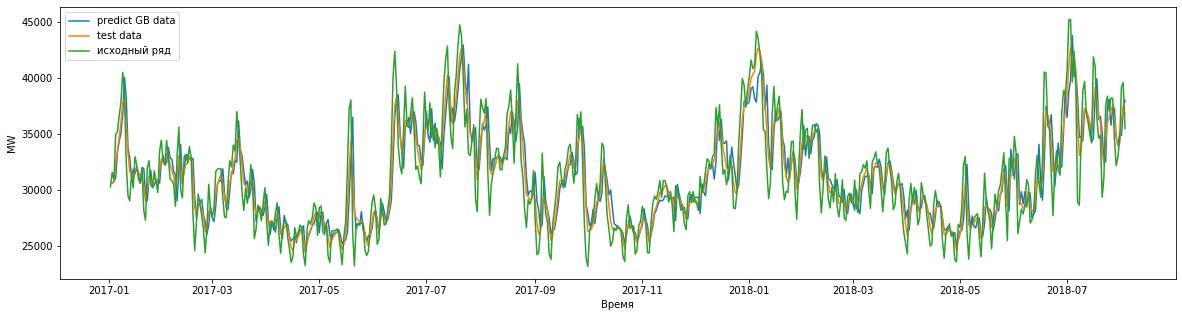

ошибка градиентного бустинга:  2.6314809790403197 %


In [20]:
X_test_pred_gb = model_gb.predict(X_test)

plt.figure(figsize=(20, 5))

plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(test.index[1:],X_test_pred_gb, label='predict GB data')
plt.plot(test.index[1:],y_test, label='test data')
plt.plot(data_s.loc['2017-01-02':].index, data_s.loc['2017-01-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга: ', er_g, '%')

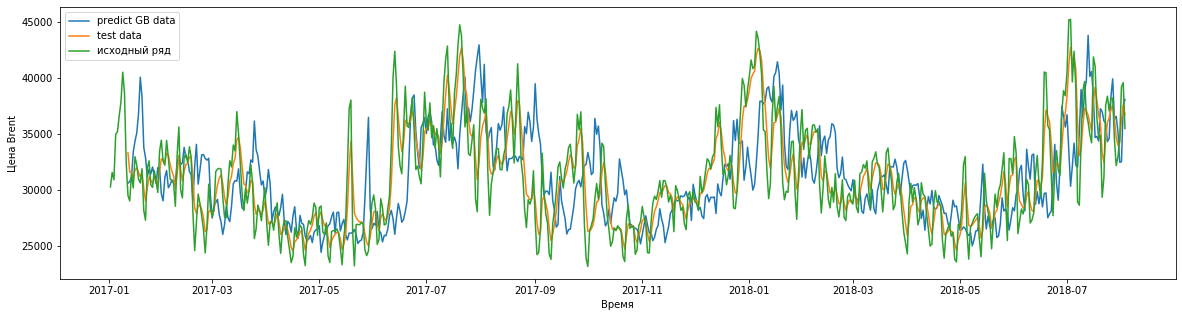

ошибка градиентного бустинга:  8.923995430520689 %


In [21]:
h=10
X_train = train.iloc[:-h,:]
y_train = train[df.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[df.columns[0]].values[h:]

X_test_pred_gb = model_gb.predict(X_test)

plt.figure(figsize=(20, 5))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test.index[h:],X_test_pred_gb, label='predict GB data')
plt.plot(test.index[h:],y_test, label='test data')
plt.plot(data_s.loc['2017-01-02':].index, data_s.loc['2017-01-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга: ', er_g, '%')

### 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Ошибка для горизонта прогноза 1 составляет 2.63%. Мы добавили много признаков, но не оценили насколько они значимы. Для точной оценки сезонности надо брать достаточно большой интервал времени, чтобы в него эта сезонность попала. Для горизонта прогноза 10 качество заметно падает, это видно из графика, и составляет 8.92%.

### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).
    Это нестационарный ряд с сезоном и циклом, т.к. есть зависимость от времени суток и времени года.

б) Количество денег, которые тратят покупатели в интернет магазине.
    Это нестационарный ряд с трендом и сезоном. Если магазин успешный (или нет), то у него будет тренд на увеличение (уменьшение) объемов продаж.

в) Вес растущего котенка.
    Нестационарный ряд с трендом на увеличение веса (пока не вырастет оконательно), он не будет колебаться вокруг одного значения. Без сезонов и циклов, т.к. рост не зависит от времени года.

г) Прирост объема деревьев в лесу от времени
    Это стационарный ряд, т.к. старые дересья будут погибать, а новые вырастать. Если, конечно, не будут учтены какие-то другие факторы.